In [1]:
import csv 
import networkx as nx
import matplotlib.pyplot as plt
import math
from graph import Graph
from article import Article
import random
import pandas as pd
import seaborn as sns
import mplcursors 
import numpy as np
from tqdm import tqdm

In [2]:
cs_graph = Graph()
cs_graph.update_graph("data/categories.tsv", mode='Initialization')
cs_graph.update_graph("data/paths_finished.tsv", mode='common_sense_edges', verbose=True,paths_mode=True) 
cs_graph.update_graph("data/paths_unfinished.tsv", mode='common_sense_edges', verbose=True,paths_mode=True,finished=False)

The graph has 4598 articles, 127 categories, and 15 topics.
The number of edges is :
50341 in the articles graph,
6524 in the categories graph,
208 in the topics graph.
The graph has 4598 articles, 127 categories, and 15 topics.
The number of edges is :
57558 in the articles graph,
6925 in the categories graph,
208 in the topics graph.


In [3]:
links_df = pd.read_csv('data/links_df_filtered.csv')

In [4]:
def divide_column_into_bins(df, column, bin_size):
  # Create the bins
  bins = range(0, int(df[column].max()) + bin_size, bin_size)

  # Create a new column that contains the binned values
  df["binned"] = pd.cut(df[column], bins)

  return df

In [5]:
links_df.head(5)

,article_from,article_to,topics_related,weight,position,nb_links,relative_position,position_duplicates,relative_position_duplicates,explored,inner,topics_related_int
0,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Bede,People_History,0,7,11,64.0,7,64.0,0,0,0
1,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Columba,People_People,0,3,11,27.0,3,27.0,0,1,1
2,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Great_Britain,People_Citizenship,0,4,11,36.0,4,36.0,0,0,2
3,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Isle_of_Man,People_Geography,0,6,11,55.0,6,55.0,0,0,3
4,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Monarchy,People_Citizenship,0,0,11,0.0,0,0.0,0,0,2


In [6]:

dict_paths = {}
paths = cs_graph.paths

paths_positions = []
print(len(paths))
groups = links_df.groupby(['article_from','article_to'])
nbr_errors = 0
for i in tqdm(range(0,len(paths)-1)):
    
    pos = []
    relative_pos = []
    for j in range(0,len(paths[i])-1):
        try:
            temp_df = groups.get_group((paths[i][j],paths[i][j+1]))
        except Exception as e:
            nbr_errors += 1
            pos.append(np.nan)
            relative_pos.append(np.nan)
            continue
        pos.append(temp_df['position'].item())
        relative_pos.append(temp_df['relative_position'].item())
    pos_mean = np.nanmean(pos)
    relative_mean = np.nanmean(relative_pos)
    dict_paths[i] = [paths[i],len(paths[i]),pos,pos_mean,relative_pos,relative_mean,cs_graph.finished[i]]
print(nbr_errors)

76193


  0%|          | 1/76192 [00:00<4:47:14,  4.42it/s]C:\Users\Mahdi\AppData\Local\Temp\ipykernel_30420\871449411.py:22: RuntimeWarning: Mean of empty slice
  pos_mean = np.nanmean(pos)
C:\Users\Mahdi\AppData\Local\Temp\ipykernel_30420\871449411.py:23: RuntimeWarning: Mean of empty slice
  relative_mean = np.nanmean(relative_pos)
100%|██████████| 76192/76192 [00:42<00:00, 1778.68it/s]

149486


In [7]:
paths_df = pd.DataFrame.from_dict(dict_paths, orient='index', columns=['paths', 'path_length', 'link_positions','position_mean','relative_pos','relative_mean','finished'])

In [8]:
paths_df = paths_df[paths_df['path_length'] > 1]

In [9]:
paths_df.sample(20)

,paths,path_length,link_positions,position_mean,relative_pos,relative_mean,finished
19161,"[Socialism, Ecology, Life, Cell_%28biology%29,...",6,"[35, nan, nan, nan, 15]",25.000000,"[85.0, nan, nan, nan, 50.0]",67.500000,True
38013,"[Duran_Duran, Atlantic_Ocean, Tide, Full_moon]",4,"[12, 21, nan]",16.500000,"[36.0, 17.0, nan]",26.500000,True
24842,"[Massospondylus, South_Africa, Zimbabwe, Mozam...",11,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, 12]",12.000000,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",18.000000,True
29344,"[Oman, United_Kingdom, Tennis, Real_tennis]",4,"[12, nan, nan]",12.000000,"[50.0, nan, nan]",50.000000,True
59807,"[Theatre, France, Sub-Saharan_Africa, South_Af...",8,"[nan, 70, nan, nan, nan, nan, nan]",70.000000,"[nan, 82.0, nan, nan, nan, nan, nan]",82.000000,False
26851,"[Protoceratops, Fossil, Evolution, Creation-ev...",5,"[nan, 10, nan, nan]",10.000000,"[nan, 42.0, nan, nan]",42.000000,True
11621,"[San_Jose%2C_California, Russia, Kazakhstan, A...",4,"[21, nan, nan]",21.000000,"[38.0, nan, nan]",38.000000,True
70055,"[Lord_Voldemort, Latin, Italy]",3,"[1, 12]",6.500000,"[6.0, 41.0]",23.500000,False
42039,"[Lavender, Ancient_Rome, North_Africa, Europe,...",8,"[11, 38, 22, nan, 7, 15, nan]",18.600000,"[79.0, 43.0, 67.0, nan, 8.0, 79.0, nan]",55.200000,True
56444,"[Asteroid, 4_Vesta, Solar_System, Mars, Soviet...",5,"[nan, nan, nan, 38]",38.000000,"[nan, nan, nan, 63.0]",63.000000,False


In [10]:
def check_nan(L):
    for i in L:
        if math.isnan(i):
            return True

    return False

In [11]:
paths_df['contains_nan'] = paths_df.apply(lambda row: check_nan(row['link_positions']),axis=1)
paths_df = paths_df[~ paths_df['contains_nan']]

In [12]:
filtered_paths_df = paths_df[paths_df['path_length']<100]

In [13]:
filtered_paths_df.head()

,paths,path_length,link_positions,position_mean,relative_pos,relative_mean,finished,contains_nan
8,"[14th_century, Time, Light, Rainbow]",4,"[3, 34, 13]",16.666667,"[10.0, 81.0, 24.0]",38.333333,True,False
9,"[14th_century, 15th_century, Plato, Nature, Ul...",7,"[1, 27, 24, 28, 2, 6]",14.666667,"[3.0, 47.0, 55.00000000000001, 41.0, 6.0, 32.0]",30.666667,True,False
12,"[14th_century, Time, Astronomy, Light, Rainbow]",5,"[3, 10, 42, 13]",17.000000,"[10.0, 24.0, 56.00000000000001, 24.0]",28.500000,True,False
21,"[14th_century, Christianity, Religion, Astrolo...",7,"[16, 0, 41, 10, 9, 6]",13.666667,"[52.0, 0.0, 87.0, 21.0, 16.0, 32.0]",34.666667,True,False
22,"[14th_century, Time, Light, Rainbow]",4,"[3, 34, 13]",16.666667,"[10.0, 81.0, 24.0]",38.333333,True,False


In [14]:
filtered_paths_df['position_mean'].mean()

20.67208799796111

<AxesSubplot:>

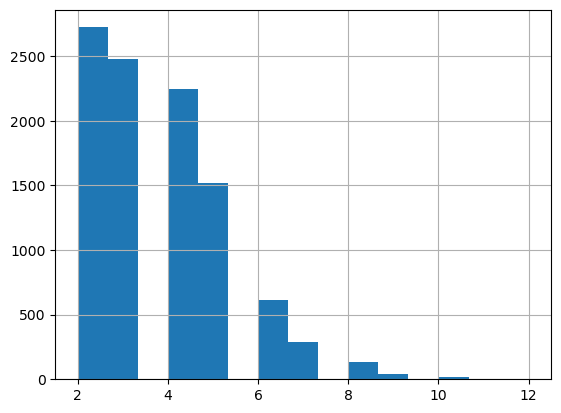

In [27]:
filtered_paths_df['path_length'].hist(bins=15)

In [26]:
new_df = divide_column_into_bins(filtered_paths_df, 'position_mean', 20)

In [16]:
df_mean = new_df.groupby('binned').mean()

<AxesSubplot:xlabel='binned'>

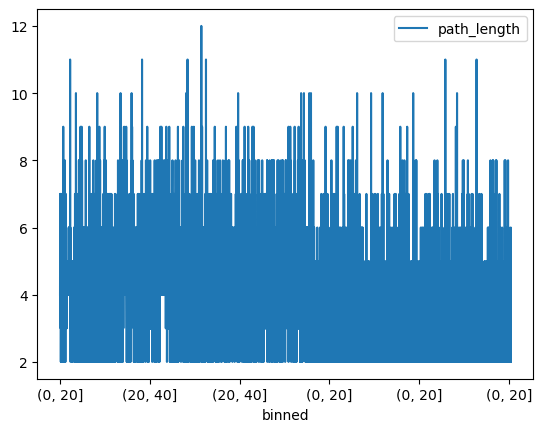

In [28]:
new_df.plot(y='path_length',x='binned')

In [17]:
new_df.groupby('binned').count()

,paths,path_length,link_positions,position_mean,relative_pos,relative_mean,finished,contains_nan
binned,,,,,,,,
"(0, 20]",5857,5857,5857,5857,5857,5857,5857,5857
"(20, 40]",2820,2820,2820,2820,2820,2820,2820,2820
"(40, 60]",796,796,796,796,796,796,796,796
"(60, 80]",237,237,237,237,237,237,237,237
"(80, 100]",91,91,91,91,91,91,91,91
"(100, 120]",17,17,17,17,17,17,17,17
"(120, 140]",17,17,17,17,17,17,17,17
"(140, 160]",4,4,4,4,4,4,4,4
"(160, 180]",0,0,0,0,0,0,0,0


range(0, 320, 20)


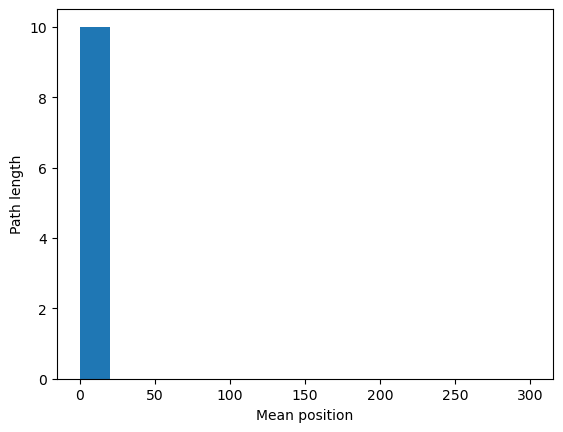

In [19]:
bins = range(0, 300 + 20, 20)
new_df = divide_column_into_bins(paths_df, 'position_mean', 20)
df_mean
print(bins)
plt.hist( new_df.groupby('binned').mean()['path_length'],bins=bins)

# Set the x-axis label
plt.xlabel("Mean position")

# Set the y-axis label
plt.ylabel("Path length")

# Show the plot
plt.show()

d:\mahdi\anaconda_pyth\envs\ada\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='position_mean', ylabel='path_length'>

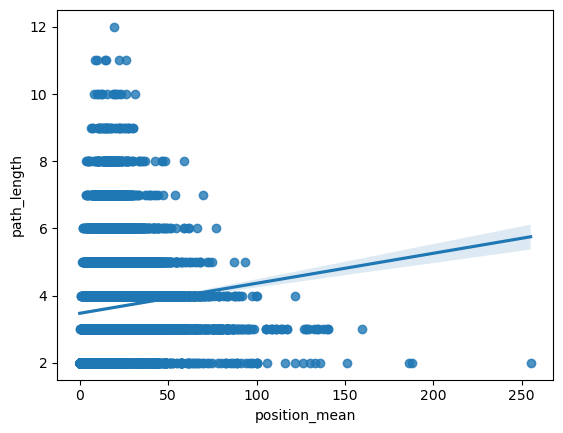

In [20]:
sns.regplot(paths_df['position_mean'],paths_df['path_length'])

<AxesSubplot:>

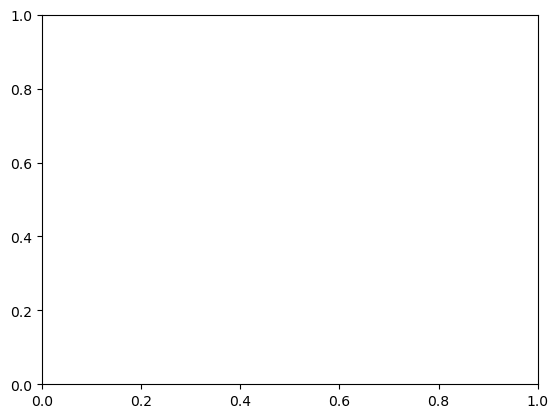

In [21]:
sns.histplot()